# Cardiovascular Disease Prediction (I Data Cleaning)

#### Project Overview

Coronary Heart Disease (CHD) remains one of the leading causes of death globally. Predicting the 10-year risk of CHD based on demographic, behavioral, and clinical data is essential for preventive healthcare.

- **[I Data Cleaning](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_I_DataCleaning.ipynb)**
- [II EDA](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_II_EDA.ipynb)
- [III Modeling](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_III_Modeling.ipynb)  
  
This initial phase of the project is dedicated to a thorough data cleaning.

#### Objective
- Handle inconsistencies such as missing values and outliers, ensuring a robust and reliable dataset is prepared for the subsequent modeling phase.

#### Dataset

Data taken from [Kaggle](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea), and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.  
It includes **16 columns** with **3,390 records**:


| Category               | Column                        | Description / Type                                               |
|------------------------|--------------------------------|-----------------------------------------------------------------|
| **Demographic**        | Sex                            | Male or female ("M" or "F")                                     |
|                        | Age                            | Age of the patient                                              |
| **Behavioral**         | is_smoking                     | Whether the patient is a current smoker ("YES" or "NO")         |
|                        | CigsPerDay                     | Number of cigarettes smoked per day                              |
| **Medical (history)**  | BPMeds                         | Whether the patient is on blood pressure medication (Nominal)    |
|                        | PrevalentStroke                | Whether the patient had a previous stroke (Nominal)             |
|                        | PrevalentHyp                   | Whether the patient is hypertensive (Nominal)                   |
|                        | Diabetes                       | Whether the patient has diabetes (Nominal)                      |
| **Medical (current)**  | TotChol                        | Total cholesterol level (Continuous)                             |
|                        | SysBP                          | Systolic blood pressure (Continuous)                              |
|                        | DiaBP                          | Diastolic blood pressure (Continuous)                             |
|                        | BMI                            | Body Mass Index (Continuous)                                      |
|                        | Heart Rate                     | Heart rate (Continuous)                                          |
|                        | Glucose                        | Glucose level (Continuous)                                       |
| **Predict variable**   | TenYearCHD                     | Binary: “1” = Yes, “0” = No                                      |


---

#### Summary

The main steps performed:

- **Data Type Conversion**
- **Outlier Handling:**
    - A single extreme outlier in sysBP (295 mmHg) was considered a data entry error and the entire record was removed.
    - Clinically meaningful outliers in totChol, cigsPerDay, and glucose were retained, as they represent high-risk cases essential for model learning.
- **Missing Value Imputation:** A targeted strategy was used to fill missing values:
    - **Mode Imputation:** Categorical features with missing data (education, BPMeds) were filled using the most frequent value (mode).
    - **Conditional & Median Imputation:** cigsPerDay was handled with specific logic: non-smokers' missing values were set to 0, while smokers' missing values were imputed with the group's median. Simple median imputation was used for totChol and heartRate.
    - **Grouped Median Imputation:** To improve accuracy, missing BMI values were filled with the median BMI calculated separately for each gender.
    - **Multivariate Imputation:** For glucose, which had the highest number of missing values, a more sophisticated approach was taken. sklearn's IterativeImputer was used to predict and fill missing values based on other related features (age, sysBP, BMI, etc.), preserving the original data distribution.

---

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [2]:
# Plot style
def set_plot_theme():
    plt.style.use("seaborn-v0_8-dark")
    sns.set_theme(
        style="dark",
        palette="deep",
        font_scale=1.2
    )
    plt.rcParams["figure.figsize"] = (20, 5)

set_plot_theme()

---

### 1. Load & Overview Data

In [3]:
df_chd = pd.read_csv("train.csv", index_col=0).sort_index()

In [4]:
df_chd.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [5]:
df_chd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [6]:
df_chd[df_chd.duplicated()]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,


### 2. Convert Data Types

In [7]:
df = df_chd.copy()

In [8]:
mappings = {
    "sex": {"F": 1, "M": 0},
    "is_smoking": {"YES": 1, "NO": 0}
}

In [9]:
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

In [10]:
categorical_feats = [
    "education", "sex", "is_smoking", "BPMeds", 
    "prevalentStroke", "prevalentHyp", "diabetes", 
    "TenYearCHD"
]

In [11]:
df[categorical_feats] = df[categorical_feats].astype("category")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              3390 non-null   int64   
 1   education        3303 non-null   category
 2   sex              3390 non-null   category
 3   is_smoking       3390 non-null   category
 4   cigsPerDay       3368 non-null   float64 
 5   BPMeds           3346 non-null   category
 6   prevalentStroke  3390 non-null   category
 7   prevalentHyp     3390 non-null   category
 8   diabetes         3390 non-null   category
 9   totChol          3352 non-null   float64 
 10  sysBP            3390 non-null   float64 
 11  diaBP            3390 non-null   float64 
 12  BMI              3376 non-null   float64 
 13  heartRate        3389 non-null   float64 
 14  glucose          3086 non-null   float64 
 15  TenYearCHD       3390 non-null   category
dtypes: category(8), float64(7), int64(1)
memory usa

---

### 3. Missing Values

In [13]:
def missing_summary(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    return (
        pd.DataFrame({
            "Missing Count": missing,
            "Missing %": (missing / len(df) * 100).round(2)
        })
    )

In [14]:
missing_summary(df)

,Missing Count,Missing %
glucose,304,8.97
education,87,2.57
BPMeds,44,1.30
totChol,38,1.12
cigsPerDay,22,0.65
BMI,14,0.41
heartRate,1,0.03


- **Instead of deleting rows with missing values, we will replace them to retain as much data as possible.**  
This is especially important in medical datasets where every patient record is valuable.

---

### 4. Outliers

In [15]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

In [16]:
def count_all_outliers(df):
    outlier_dict = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        lower_outliers = (df[col] < lower_bound).sum()
        upper_outliers = (df[col] > upper_bound).sum()

        outlier_dict[col] = {
            "Upper Outliers": upper_outliers,
            "Lower Outliers": lower_outliers  
        }

    outlier_df = pd.DataFrame.from_dict(outlier_dict, orient="index").T
    return outlier_df

In [17]:
outlier_summary_df = count_all_outliers(df_numeric)
outlier_summary_df

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
Upper Outliers,0,9,41,105,55,77,63,151
Lower Outliers,0,0,2,0,3,0,1,7


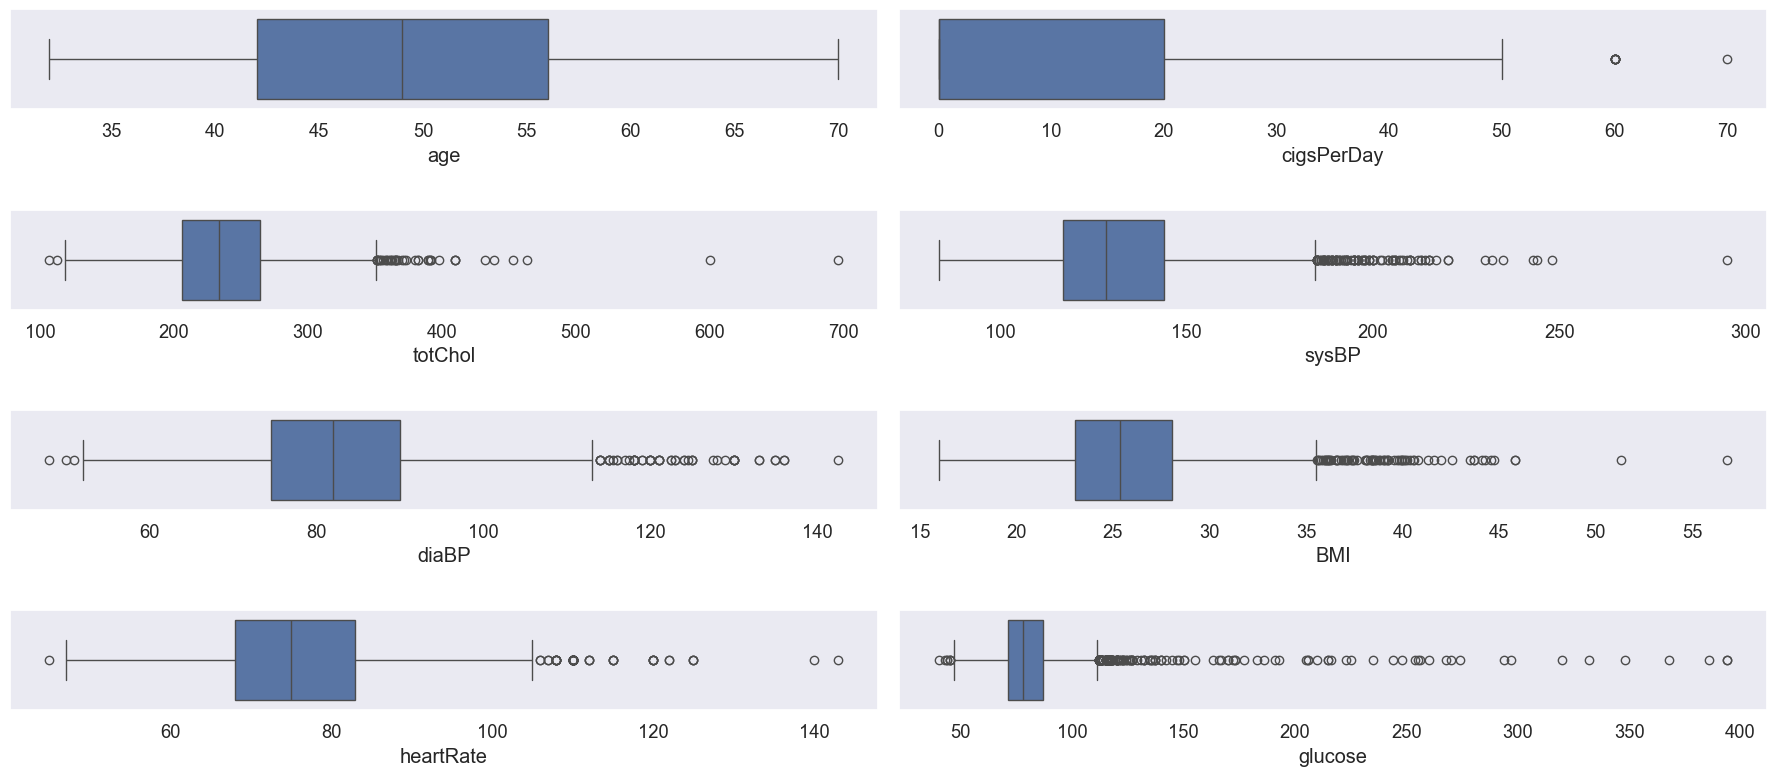

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    sns.boxplot(data=df_numeric, x=col, ax=axes[i])

plt.tight_layout()
plt.subplots_adjust(hspace=1)
plt.show()

- Outliers are present in all numerical features except Age, and they are mainly concentrated at the upper end of the distribution.
- The glucose variable has the most outliers, with 151 upper and 7 lower outliers identified.

---

### 5. Handling Missing Values & Outliers

#### 5.1. Education

In [19]:
df["education"].value_counts()

education
1.0    1391
2.0     990
3.0     549
4.0     373
Name: count, dtype: int64

`education` is a categorical variable. Using Mode for filling the missing values with most common education level (1).

In [20]:
df["education"] = df["education"].fillna(df["education"].mode()[0])

---

#### 5.2. Blood Pressure Medication (BPMeds)

In [21]:
df["BPMeds"].value_counts()

BPMeds
0.0    3246
1.0     100
Name: count, dtype: int64

Most patients are not on medication, impute with the most common category (0)

In [22]:
df["BPMeds"] = df["BPMeds"].fillna(df["BPMeds"].mode()[0])

---

#### 5.3. Cigarettes Per Day (cigsPerDay)

We'll handle missing `cigsPerDay` values by first setting them to 0 for all non-smokers. Then, we will impute the remaining missing values for smokers using the median `cigsPerDay` of that group.

In [23]:
# If is_smoking = 0 (NO), set cigsPerDay = 0
df.loc[df["is_smoking"] == 0, "cigsPerDay"] = 0

In [24]:
df.loc[df["is_smoking"] == 1, "cigsPerDay"].describe()

count    1665.000000
mean       18.345946
std        10.735196
min         1.000000
25%        10.000000
50%        20.000000
75%        20.000000
max        70.000000
Name: cigsPerDay, dtype: float64

In [25]:
# If is_smoking = 1 (YES) and cigsPerDay is missing, fill with median of cigsPerDay
smoker_median = df.loc[df["is_smoking"] == 1, "cigsPerDay"].median()

df.loc[(df["is_smoking"] == 1) & (df["cigsPerDay"].isna()), "cigsPerDay"] = smoker_median

In [26]:
df[df["cigsPerDay"] > 50]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
42,39,1.0,0,1,60.0,0.0,0,0,0,215.0,112.0,65.0,23.60,59.0,78.0,0
76,37,4.0,0,1,60.0,0.0,0,0,0,254.0,122.5,82.5,23.87,88.0,83.0,0
482,49,2.0,0,1,60.0,0.0,0,0,0,213.0,123.0,75.0,24.84,70.0,NaN,1
869,58,2.0,0,1,60.0,0.0,0,1,0,250.0,150.0,97.0,32.00,75.0,65.0,0
1774,46,1.0,0,1,60.0,0.0,0,0,0,285.0,121.0,82.0,27.62,70.0,79.0,0
2075,59,1.0,0,1,60.0,0.0,0,1,0,298.0,153.5,105.0,25.05,70.0,84.0,0
2222,48,1.0,0,1,60.0,0.0,0,0,0,232.0,136.0,81.0,25.83,80.0,78.0,0
2985,40,3.0,0,1,70.0,0.0,0,1,0,210.0,132.0,86.0,31.57,98.0,80.0,0
3374,67,2.0,0,1,60.0,0.0,0,1,0,261.0,170.0,100.0,22.71,72.0,79.0,1


Even though maximum reported smoking was 70 cigarettes/day (much higher than the mean 18), we keep these records because they represent heavy exposure relevant for CHD risk.

---

#### 5.4. Total Cholesterol Level (totChol)

Cholesterol ranges(mg/dL):
- **Normal**: <200
- **High**: 240+ 
- **Extremely high (dangerous)**: >400

Having cholesterol in the 600–700 range is extremely dangerous.

In [27]:
df["totChol"].describe()

count    3352.000000
mean      237.074284
std        45.247430
min       107.000000
25%       206.000000
50%       234.000000
75%       264.000000
max       696.000000
Name: totChol, dtype: float64

In [28]:
df[df["totChol"] > 400]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
220,47,2.0,0,1,18.0,0.0,0,1,0,439.0,145.0,74.0,22.42,100.0,90.0,1
423,52,2.0,1,0,0.0,0.0,0,1,1,600.0,159.5,94.0,28.27,78.0,140.0,1
512,51,1.0,0,1,9.0,0.0,0,1,0,696.0,157.0,87.0,24.44,95.0,84.0,0
733,42,3.0,1,0,0.0,0.0,0,0,0,464.0,128.0,87.0,22.90,72.0,72.0,1
2123,42,2.0,0,1,15.0,0.0,0,1,0,453.0,158.0,108.0,28.89,90.0,110.0,0
2445,59,1.0,1,0,0.0,0.0,0,1,0,410.0,142.0,79.0,25.58,78.0,90.0,0
2534,57,1.0,1,0,0.0,1.0,0,1,0,432.0,153.0,85.0,26.13,98.0,75.0,1
2555,52,2.0,1,1,20.0,0.0,0,0,0,410.0,105.0,67.5,27.33,75.0,90.0,0
3326,42,1.0,0,1,20.0,0.0,0,0,0,410.0,116.0,83.0,21.68,90.0,83.0,0


Cholesterol > 400 mg/dL is extremely high (normal: <200 mg/dL).
People with such extreme cholesterol levels are at **very high risk for CHD**.
Removing these rows would ignore the most severe cases, which are the ones the model should learn to predict.

Replace missing with Median.

In [29]:
df["totChol"] = df["totChol"].fillna(df["totChol"].median())

---

#### 5.5. Systolic Blood Pressure (sysBP)

Systolic Blood Pressure range:
- **Normal:** <120
- **Hypertension crisis:** >180

In [30]:
df["sysBP"].describe()

count    3390.00000
mean      132.60118
std        22.29203
min        83.50000
25%       117.00000
50%       128.50000
75%       144.00000
max       295.00000
Name: sysBP, dtype: float64

295 mmHg is more than 1.5 times higher than a hypertensive crisis. In real life:
- It’s rare and usually fatal.
- Could be a measurement error, equipment malfunction, or data entry mistake in a dataset.

In [31]:
df[df["sysBP"] > 250]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
1941,64,1.0,1,0,0.0,0.0,0,1,0,253.0,295.0,135.0,38.82,92.0,70.0,1


Before including this record in the analysis, it would be important to verify whether the value was entered correctly (e.g., 195 instead of 295). Since verification is not possible and this outlier appears only once in the dataset, we will remove it.

In [32]:
df = df[df["sysBP"] <= 290]

---

#### 5.6. Body Mass Index (BMI) 

Ranges of BMI:
- **Very dangerous:** <16 (malnutrition, muscle wasting, weakened immunity)
- **Normal:** 18.5–24.9
- **Very dangerous:** \>40 (linked to severe cardiovascular disease)
- **Clinically extreme:** \>50–60

We will impute missing BMI values using the median for each gender. This approach is more accurate as BMI distributions can differ between males and females.

`Female: sex == 1`

In [33]:
df.loc[df["sex"] == 1, "BMI"].describe()

count    1913.000000
mean       25.474381
std         4.535392
min        15.960000
25%        22.440000
50%        24.680000
75%        27.640000
max        56.800000
Name: BMI, dtype: float64

`Male: sex == 0`

In [34]:
df.loc[df["sex"] == 0, "BMI"].describe()

count    1462.000000
mean       26.205534
std         3.433138
min        16.980000
25%        23.970000
50%        26.100000
75%        28.350000
max        40.380000
Name: BMI, dtype: float64

In [35]:
gender_medians = df.groupby("sex", observed=False)["BMI"].median()

In [36]:
gender_medians

sex
0    26.10
1    24.68
Name: BMI, dtype: float64

In [37]:
# Fill missing BMI with the corresponding gender median
df["BMI"] = df.groupby("sex", observed=False)["BMI"].transform(
    lambda x: x.fillna(x.median())
)

---

#### 5.7. Heart Rate

Resting Heart Rate (RHR) for adults:
- **Bradycardia (slow):** < 60
- **Normal:** 60-100
- **Tachycardia (fast):** > 100  
\* Athletes or highly fit individuals may have 40–60 bpm.

In [38]:
df["heartRate"].describe()

count    3388.000000
mean       75.972550
std        11.970469
min        45.000000
25%        68.000000
50%        75.000000
75%        83.000000
max       143.000000
Name: heartRate, dtype: float64

In [39]:
df["heartRate"] = df["heartRate"].fillna(df["heartRate"].median())

---

#### 5.8. Glucose 

Glucose ranges (mg/dL):
- **Severe hypoglycemia:** <40  (seizures, coma, death risk)
- **Too low:** <55
- **Normal:** 70–140
- **Too high:** \>300
- **Critical:** \>400 

In [40]:
df["glucose"].describe()

count    3085.000000
mean       82.090438
std        24.247707
min        40.000000
25%        71.000000
50%        78.000000
75%        87.000000
max       394.000000
Name: glucose, dtype: float64

In [41]:
df[df["glucose"] >= 300]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
312,46,2.0,1,1,15.0,0.0,0,0,1,233.0,106.0,60.0,20.84,75.0,348.0,0
1032,67,2.0,1,0,0.0,1.0,0,1,1,303.0,204.0,96.0,27.86,75.0,394.0,1
1156,47,1.0,1,1,1.0,0.0,0,1,1,160.0,197.0,109.0,34.91,82.0,320.0,1
1587,62,3.0,0,0,0.0,0.0,0,0,1,346.0,102.5,66.5,17.17,80.0,394.0,1
2188,62,3.0,1,1,20.0,1.0,0,1,1,358.0,215.0,110.0,37.62,110.0,368.0,1
2703,47,2.0,0,1,20.0,0.0,0,1,1,296.0,141.0,93.0,28.50,68.0,332.0,1
3042,62,1.0,1,0,0.0,0.0,0,0,1,233.0,130.0,87.0,21.34,85.0,386.0,0


Although the maximum glucose value in the dataset is **394 mg/dL**, which is much higher than the mean of 82 mg/dL, will keep these records. Extreme glucose levels may indicate undiagnosed or poorly controlled diabetes, which is a strong risk factor for CHD.

---

Since the glucose column had the most missing values and is a key predictor of TenYearCHD risk, we applied `IterativeImputer` to estimate missing values based on other related numeric features.

In [42]:
df_imputed = df.copy()

In [43]:
predictor_features = ["age", "totChol", "sysBP", "diaBP", "BMI", "heartRate"]
temp = df_imputed[predictor_features + ["glucose"]]

In [44]:
imputer = IterativeImputer(random_state=42, max_iter=10)

In [45]:
imputed_data = imputer.fit_transform(temp)

In [46]:
temp_imputed = pd.DataFrame(imputed_data, columns=temp.columns, index=temp.index)
df_imputed["glucose"] = temp_imputed["glucose"]

#### Quality check of data imputation

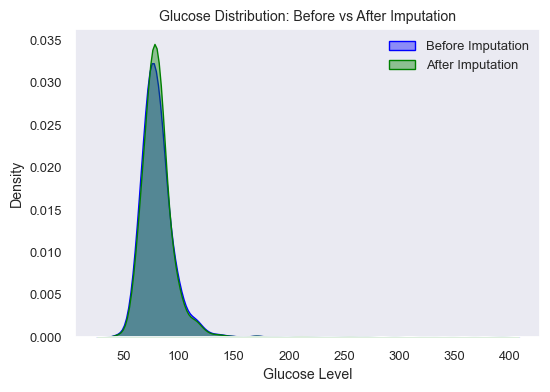

In [47]:
sns.set_context("notebook", font_scale=0.85) 

plt.figure(figsize=(6, 4))
sns.kdeplot(df["glucose"], color="blue", label="Before Imputation", fill=True, alpha=0.4)
sns.kdeplot(df_imputed["glucose"], color="green", label="After Imputation", fill=True, alpha=0.4)

plt.title("Glucose Distribution: Before vs After Imputation")
plt.xlabel("Glucose Level")
plt.ylabel("Density")
plt.legend()

plt.show()

**Observation:** Imputation method was successful and appropriate. It filled in the missing glucose values without significantly changing the original distribution of the data.

---

### 6. Dataset Checkup

In [48]:
missing_summary(df_imputed)

,Missing Count,Missing %


In [49]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3389 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              3389 non-null   int64   
 1   education        3389 non-null   category
 2   sex              3389 non-null   category
 3   is_smoking       3389 non-null   category
 4   cigsPerDay       3389 non-null   float64 
 5   BPMeds           3389 non-null   category
 6   prevalentStroke  3389 non-null   category
 7   prevalentHyp     3389 non-null   category
 8   diabetes         3389 non-null   category
 9   totChol          3389 non-null   float64 
 10  sysBP            3389 non-null   float64 
 11  diaBP            3389 non-null   float64 
 12  BMI              3389 non-null   float64 
 13  heartRate        3389 non-null   float64 
 14  glucose          3389 non-null   float64 
 15  TenYearCHD       3389 non-null   category
dtypes: category(8), float64(7), int64(1)
memory usa

In [50]:
df_imputed["BPMeds"] = df_imputed["BPMeds"].astype(int)
df_imputed["education"] = df_imputed["education"].astype(int)

In [51]:
df_imputed.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2,1,1,3.0,0,0,0,0,221.0,148.0,85.0,24.68,90.0,80.0,1
1,36,4,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


---

### 7. Save the dataset

In [52]:
int_cats = ["education", "sex", "is_smoking", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "TenYearCHD"]

In [53]:
for col in int_cats:
    df[col] = df[col].astype(str)

In [54]:
# Save to Parquet
df_imputed.to_parquet("df_chd_cleaned.parquet")

---

Following parts:
- [II EDA](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_II_EDA.ipynb)
- [III Modeling](https://github.com/TuringCollegeSubmissions/msedui-PYDA.4.4/blob/main/CHD_III_Modeling.ipynb)  